# Fine-tuning ELECTRA for binary classification (2 labels)

This Jupyter Notebook performs fine-tuning of the ELECTRA-small-discriminator model for a binary classification.
For more details on the ELECTRA-small-discriminator model, visit: https://huggingface.co/google/electra-small-discriminator

## Import of libraries and set of the structure for training

In [3]:
import pandas as pd
from datasets import Dataset, load_dataset, Dataset, DatasetDict, Features, Value
from transformers import ElectraConfig, ElectraTokenizer, ElectraForSequenceClassification, Trainer, TrainingArguments, TrainerCallback, logging
import torch
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
import numpy as np
import random
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns

seed_value = 1999

random.seed(seed_value)
torch.manual_seed(seed_value)
np.random.seed(seed_value)

## Loading the datasets and organizing them into a DatasetDict.
The datasets are loaded from source files and then structured in a DatasetDict for easy manipulation and training

In [4]:
# Absolute path to the .csv file
train_csv_path = '../../data/New dataset/BERT/train_tweets_Transformers_new_binary.csv'
eval_csv_path = '../../data/New dataset/BERT/eval_tweets_Transformers_new_binary.csv'
test_csv_path = '../../data/New dataset/BERT/test_tweets_Transformers_new_binary.csv'

In [5]:
# Dataset loading
train_df = pd.read_csv(train_csv_path)
eval_df = pd.read_csv(eval_csv_path)
test_df = pd.read_csv(test_csv_path)

# Shuffling of datasets
train_df = train_df.sample(frac=1).reset_index(drop=True)
eval_df = eval_df.sample(frac=1).reset_index(drop=True)
test_df = test_df.sample(frac=1).reset_index(drop=True)

# Structuring of the data in DatasetDict class
dataset = DatasetDict()
dataset['train'] = Dataset.from_pandas(train_df)
dataset['test'] = Dataset.from_pandas(test_df)
dataset['validation'] = Dataset.from_pandas(eval_df)
dataset.shape

{'train': (9904, 2), 'test': (2674, 2), 'validation': (2490, 2)}

## Preprocess data

### Defining the model-specific **tokenizer**

In [6]:
# Preprocessing
tokenizer = ElectraTokenizer.from_pretrained("google/electra-small-discriminator")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

### Class conversion the numeric label

In [7]:
from sklearn.preprocessing import LabelEncoder
possible_labels = train_df.cyberbullying_type.unique()

le = LabelEncoder()
label_dict = le.fit_transform(possible_labels)

In [8]:
le.classes_

array([0, 1])

### Function definied to preprocess the data

In [9]:
def preprocess_function(examples):
    encoded_example=tokenizer(examples["tweet_text"], padding="max_length", truncation=True, max_length=70, return_tensors="pt")
    encoded_example["label"] = label_dict[le.transform(examples["cyberbullying_type"])]
    return encoded_example

In [10]:
encoded_dataset = dataset.map(preprocess_function, batched=True, remove_columns=dataset['train'].column_names)

Map:   0%|          | 0/9904 [00:00<?, ? examples/s]

Map:   0%|          | 0/2674 [00:00<?, ? examples/s]

Map:   0%|          | 0/2490 [00:00<?, ? examples/s]

In [11]:
# Convert datasets to PyTorch tensors
encoded_dataset.set_format("torch")

## Model setup

### Creating an instance of ELECTRA with customised parameters

In [12]:
# Preparing the model

# Create a custom configuration with dropout
config = ElectraConfig.from_pretrained(
    'google/electra-small-discriminator',
    hidden_dropout_prob=0.3,  # Set the dropout rate
    attention_probs_dropout_prob=0.5,  # Set the dropout rate for attention
    num_labels=5
)

# Create template with custom configuration
model = ElectraForSequenceClassification.from_pretrained(
    'google/electra-small-discriminator',
    config=config
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


pytorch_model.bin:   0%|          | 0.00/54.2M [00:00<?, ?B/s]

Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-small-discriminator and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Trainer setup

### Defining the TrainingArguments

The best parameters are obtained using grid search.
Including an early stopping callback to halt training when performance stops improving.
TrainingArguments specify the hyperparameters for the training process such as learning rate, batch size, and number of epochs.
Early stopping is used to prevent overfitting by stopping the training when the validation loss stops decreasing.

In [13]:
# Definition of training parameters
from transformers import EarlyStoppingCallback

training_args = TrainingArguments(
    output_dir='./results',
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=1e-4,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=10,
    logging_steps=100,
    load_best_model_at_end=True,  # Load the best model at the end
    metric_for_best_model="eval_loss",  # Metric for the best model
)

early_stopping_callback = EarlyStoppingCallback(early_stopping_patience=2)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


### Definition of a customised compute metrics callback to keep track of parameters that would otherwise be lost

In [14]:
class ComputeMetricsCallback(TrainerCallback):
    def __init__(self):
        self.train_accuracies = []
        self.eval_accuracies = []

    def on_epoch_end(self, args, state, control, **kwargs):
        # Calculates the accuracy on the training set
        train_predictions = trainer.predict(trainer.train_dataset)
        train_accuracy = accuracy_score(train_predictions.label_ids, np.argmax(train_predictions.predictions, axis=1))
        self.train_accuracies.append(train_accuracy)

        # Calculates the accuracy on the validation set
        eval_predictions = trainer.predict(trainer.eval_dataset)
        eval_accuracy = accuracy_score(eval_predictions.label_ids, np.argmax(eval_predictions.predictions, axis=1))
        self.eval_accuracies.append(eval_accuracy)

        # Update logs only if a previous log exists
        if state.log_history:
          state.log_history[-1]['train_accuracy'] = train_accuracy
          state.log_history[-1]['eval_accuracy'] = eval_accuracy
        else:
          state.log_history.append({'train_accuracy': train_accuracy, 'eval_accuracy': eval_accuracy})

# Personalised evaluation function
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    acc = accuracy_score(labels, preds)
    f1 = f1_score(labels, preds, average='weighted')

    return {
        'accuracy': acc,
        'f1': f1,
    }

In [15]:
# Defining the device to be used for training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

ElectraForSequenceClassification(
  (electra): ElectraModel(
    (embeddings): ElectraEmbeddings(
      (word_embeddings): Embedding(30522, 128, padding_idx=0)
      (position_embeddings): Embedding(512, 128)
      (token_type_embeddings): Embedding(2, 128)
      (LayerNorm): LayerNorm((128,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.3, inplace=False)
    )
    (embeddings_project): Linear(in_features=128, out_features=256, bias=True)
    (encoder): ElectraEncoder(
      (layer): ModuleList(
        (0-11): 12 x ElectraLayer(
          (attention): ElectraAttention(
            (self): ElectraSelfAttention(
              (query): Linear(in_features=256, out_features=256, bias=True)
              (key): Linear(in_features=256, out_features=256, bias=True)
              (value): Linear(in_features=256, out_features=256, bias=True)
              (dropout): Dropout(p=0.5, inplace=False)
            )
            (output): ElectraSelfOutput(
              (dense): Li

In [16]:
#forward pass
outputs = model(input_ids=encoded_dataset['train']['input_ids'][0].unsqueeze(0).to(device), attention_mask=encoded_dataset['train']['attention_mask'][0].unsqueeze(0).to(device)
,labels=encoded_dataset['train'][0]['label'].unsqueeze(0).to(device))

### Creation of customised trainer

In [17]:
mycallback = ComputeMetricsCallback()

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=encoded_dataset["train"],
    eval_dataset=encoded_dataset["validation"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[mycallback, early_stopping_callback]
)

## Training phase

In [18]:
# Model training
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.383300,0.452438,0.845783,0.843989
2,0.285000,0.415380,0.878715,0.878180
3,0.241400,0.374438,0.891968,0.891733
4,0.226400,0.482599,0.889157,0.888758
5,0.205900,0.362837,0.903213,0.903044
6,0.196900,0.258726,0.918876,0.918833
7,0.188000,0.367192,0.904016,0.903855
8,0.175600,0.358320,0.905622,0.905451


TrainOutput(global_step=2480, training_loss=0.2669131782747084, metrics={'train_runtime': 249.6315, 'train_samples_per_second': 396.745, 'train_steps_per_second': 12.418, 'total_flos': 318713916218880.0, 'train_loss': 0.2669131782747084, 'epoch': 8.0})

## Plot of the results obtained by the finetuined model

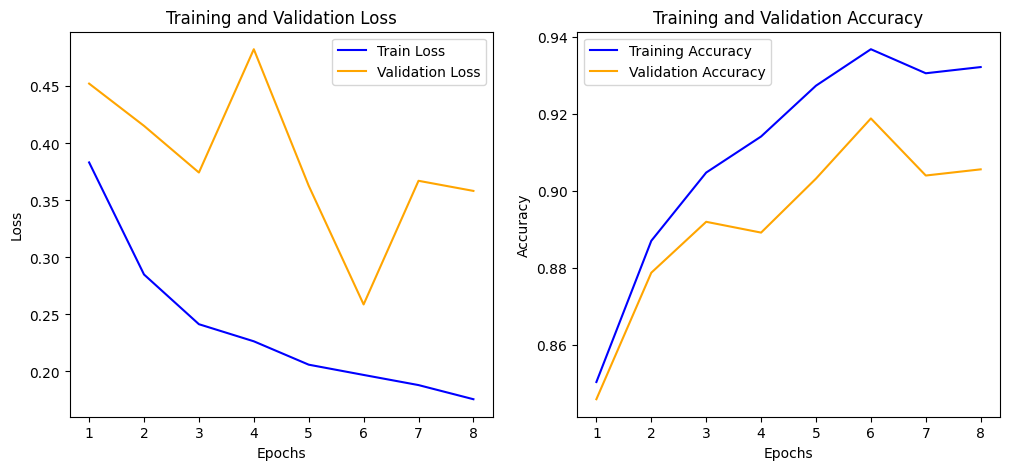

In [19]:
import matplotlib.pyplot as plt

# Retrieve training logs
history = trainer.state.log_history

# Extract loss and accuracy values
train_loss = [log['loss'] for log in history if 'loss' in log]
train_loss = [train_loss[i] for i in range(2, len(train_loss), 3)]
eval_loss = [log['eval_loss'] for log in history if 'eval_loss' in log]
train_accuracy = mycallback.train_accuracies
eval_accuracy = mycallback.eval_accuracies

# Create graphs

plt.figure(figsize=(12, 5))

# Loss chart
plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_loss) + 1), train_loss, label='Train Loss', color='blue')
plt.plot(range(1, len(eval_loss)+1), eval_loss, label='Validation Loss', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

# Accuracy graph
plt.subplot(1, 2, 2)
plt.plot(range(1, len(train_accuracy) + 1), train_accuracy, label='Training Accuracy', color='blue')
plt.plot(range(1, len(eval_accuracy) + 1), eval_accuracy, label='Validation Accuracy', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.show()

In [20]:
train_loss

[0.3833, 0.285, 0.2414, 0.2264, 0.2059, 0.1969, 0.188, 0.1756]

In [21]:
# Saving the model
trainer.save_model("./ELECTRA_binary_finetuned")

## Plot of the results obtained by the finetuined model

Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.90      0.92      1246
           1       0.90      0.94      0.92      1244

    accuracy                           0.92      2490
   macro avg       0.92      0.92      0.92      2490
weighted avg       0.92      0.92      0.92      2490

	***************************


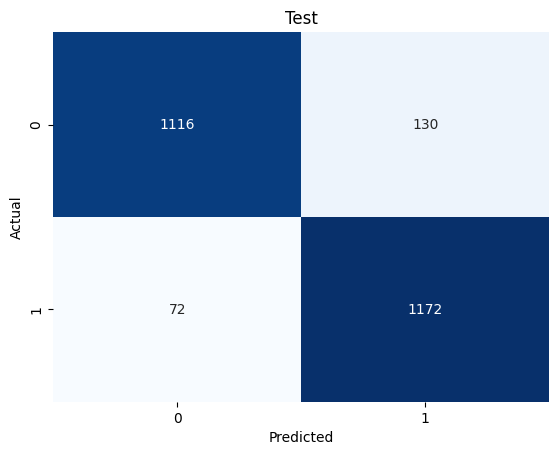

In [22]:
# Obtain predictions from the model on the validation dataset
predictions, labels, _ = trainer.predict(encoded_dataset["validation"])

# The predictions are returned as logits, so we apply argmax to get the predicted label
predicted_labels = np.argmax(predictions, axis=1)

# Compute classification report
report = classification_report(labels, predicted_labels)
print("Classification Report:\n", report)

print("\t***************************")

# Get the sorted list of unique class labels
classes = sorted(train_df['cyberbullying_type'].unique())

# Calculate confusion matrix
cm = confusion_matrix(labels, predicted_labels)

# Plot confusion matrix with title
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes, cbar=False)
plt.title("Test")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

## Test phase

In [23]:
# Final evaluation on the test dataset
test_results = trainer.evaluate(encoded_dataset["test"])
print("Test results:", test_results)

Test results: {'eval_loss': 0.2718181908130646, 'eval_accuracy': 0.9162303664921466, 'eval_f1': 0.9161974566969195, 'eval_runtime': 1.8162, 'eval_samples_per_second': 1472.275, 'eval_steps_per_second': 46.249, 'epoch': 8.0}


Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.90      0.91      1338
           1       0.90      0.94      0.92      1336

    accuracy                           0.92      2674
   macro avg       0.92      0.92      0.92      2674
weighted avg       0.92      0.92      0.92      2674

	***************************


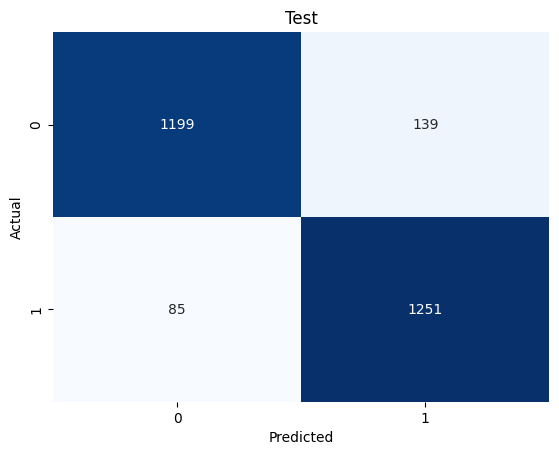

In [24]:
# Obtain predictions from the model on the validation dataset.
predictions, labels, _ = trainer.predict(encoded_dataset["test"])

# The predictions are returned as logits, so we apply argmax to get the predicted label
predicted_labels = np.argmax(predictions, axis=1)

# Compute classification report
report = classification_report(labels, predicted_labels)
print("Classification Report:\n", report)

print("\t***************************")

# Get the sorted list of unique class labels
classes = sorted(train_df['cyberbullying_type'].unique())

# Calculate confusion matrix
cm = confusion_matrix(labels, predicted_labels)

# Plot confusion matrix with title
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes, cbar=False)
plt.title("Test")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()